In [35]:
from google.colab import drive
drive.mount('/content/drive')

!pip install transformers pandas matplotlib tqdm --upgrade --quiet
!pip install cohere --quiet
!pip install -U kaleido --quiet

import cohere
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from transformers import pipeline
import torch
import torch.nn.functional as F
import plotly.graph_objects as go
import random

from google.colab import userdata
import os

os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')
os.environ["OPEN_AI"] = userdata.get("OPEN_AI")
os.environ["HF_API_KEY"] = userdata.get("HF_API_KEY")
os.environ["COHERE_API"] = userdata.get("COHERE_API")

!pip install --upgrade openai transformers --quiet
from openai import OpenAI

from pathlib import Path

path = Path('/content/drive/MyDrive/PhD with Rawat/milanlp/ngo_output')

class Stats():
    def __init__ (self):
      self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def exploratory_data_analysis(self, data, name, text):
      data[f'{name}_length'] = data[text].str.len() #gives an idea of the overall character size of the text.
      data[f'{name}_word_count'] = data[text].str.len() if text else 0 #focuses on the number of words or tokens.
      # provides insights into how long the words are on average.
      data[f'{name}_mean_word_length'] = data[text].apply(lambda x: np.mean([len(word) for word in str(x).split() if word])) if text else 0
      return data

    def plot_mean_word_length(self, dataset, name1, name2, name3, name4):
      mean_word_length_1 = dataset[f'{name1}_word_count'].mean()
      mean_word_length_2 = dataset[f'{name2}_word_count'].mean()
      mean_word_length_3 = dataset[f'{name3}_word_count'].mean()
      mean_word_length_4 = dataset[f'{name4}_word_count'].mean()
      results_df = pd.DataFrame({

          "Dataset": [name1, name2, name3, name4],
          "Mean Word Length": [mean_word_length_1, mean_word_length_2, mean_word_length_3, mean_word_length_4]
      })

      # results_df.set_index("Dataset", inplace=True)

      plot_filename = f"word_distri_{name1}_vs_{name2}_vs_{name3}_and_{name4}.png"
      plt.figure(figsize=(7, 4))
      # results_df.plot(kind='barh', legend=False, figsize=(15, 10), color=['skyblue', 'salmon', 'green', 'orange'])
      plt.barh(results_df["Dataset"], results_df["Mean Word Length"], color=['skyblue', 'salmon', 'green', 'orange'])
      plt.ylabel("dataset")
      plt.xlabel("Mean Word Length")
      plt.title("Mean Word Length Comparison")
      plt.tight_layout()
      plt.savefig(path/plot_filename)
      plt.show()

# docu:https://huggingface.co/SamLowe/roberta-base-go_emotions
class BERTemotion():
    def __init__(self, emotion_colors=None, max_length = 512, task ="text-classification",  sent_model_name="SamLowe/roberta-base-go_emotions"):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.max_length = max_length
        self.classifier = pipeline(task="text-classification", model=sent_model_name, top_k=True, device=0 if torch.cuda.is_available() else -1)
        self.emotion_colors = {
                      "admiration": "gold",
                      "anger": "cadetblue",
                      "approval": "orange",
                      "caring": "pink",
                      "curiosity": "darkviolet",
                      "desire": "cornflowerblue",
                      "disappointment": "bisque",
                      "disapproval": "moccasin",
                      "disgust": "silver",
                      "love": "turquoise",
                      "neutral": "tomato",
                      "optimism": "yellow",
                      "sadness": "pink"
                  }

    def predict(self, text):
        truncated_text = text[:self.max_length]
        model_outputs = self.classifier(truncated_text)
        return {
            "emotion": model_outputs[0][0]['label'],
            "emotion_score": model_outputs[0][0]['score']
        }

    def plot_emotion_distribution(self, emotion_labels1, emotion_labels2, emotion_labels3, emotion_labels4, name1, name2, name3, name4, model_name = 'Roberta_Base_go'):
          """Plots sentiment distribution."""
          emotion_counts_1 = emotion_labels1.value_counts()# Count the sentiment labels for each dataset
          emotion_counts_2 = emotion_labels2.value_counts()
          emotion_counts_3 = emotion_labels3.value_counts()
          emotion_counts_4 = emotion_labels4.value_counts()

          # Create a DataFrame to hold the counts for both datasets
          emotion_dict = pd.DataFrame({
              name1: emotion_counts_1,
              name2: emotion_counts_2,
              name3: emotion_counts_3,
              name4: emotion_counts_4
          }).fillna(0).sort_index()

          # print(f'this is the emotion_dict:{emotion_dict.head}')

          # Ensure consistent order of emotions across datasets
          # emotion_dict = emotion_dict.sort_index()

          # Plot the bar chart
          emotion_dist = f"emotion_dict_{name1}_{name2}_{name3}_{name4}.png"
          emotion_dict.plot(kind='barh', stacked=False, figsize=(15, 10), color=['green', 'red', 'blue', 'orange'])
          plt.title(f'{model_name} emotion Labels Distribution Across Datasets')
          plt.ylabel('Emotions')
          plt.xlabel('Counts')
          plt.legend(title="Datasets", loc='upper right')
          plt.savefig(path/emotion_dist)
          plt.show()


    def random_color(self):
          return f"#{random.randint(0, 0xFFFFFF):06x}"

    def emotion_counts(self, data):
      return data.value_counts().to_dict()

    def create_sankey_chart(self, data, col_name, path=path):
        emotion_count_dict = self.emotion_counts(data)
        all_emotions = list(emotion_count_dict.keys())
        nodes = all_emotions + [col_name]
        node_indices = {node: idx for idx, node in enumerate(nodes)}

        links = {
            "source": [],
            "target": [],
            "value": [],
            "color": []
        }

        for emotion, count in emotion_count_dict.items():
            links["source"].append(node_indices[emotion])
            links["target"].append(node_indices[col_name])
            links["value"].append(count)
            # links["color"].append(self.random_color())
            links['color'].append(self.emotion_colors.get(emotion.lower(), "black"))  # Default to gray if emotion not found


        fig = go.Figure(go.Sankey(
            node=dict(
                pad=15,
                thickness=20,
                line=dict(color="black", width=0.5),
                label=nodes
            ),
            link=dict(
                source=links["source"],
                target=links["target"],
                value=links["value"],
                color=links["color"]
            )
        ))
        sankey_chart = f"sankey_chart_for_{col_name}.png"
        fig.update_layout(title_text=f"Emotion Flow for {col_name}", font_size=10)
        fig.write_image(path/sankey_chart)
        fig.show()

class Cohere_ai:
    def prompt_counter(self, event, model_name= 'command'):

      prompt = f"generate a counter-narrative to this hateful comment '{event}'. omit explanations and provide only the counter narrative"

      co_api = cohere.Client(userdata.get("COHERE_API"))

      response = co_api.chat(
          message=prompt,
          model=model_name,
          temperature=0.3
      )

      return response.text

class LLM_sentiment:

    def sentiment_gpt(self, event, model_name):

      prompt = f"classify this {event} as either positive or negative. omit all explanation and provide only the class"

      client = OpenAI(
          api_key = userdata.get("OPENAI_KEY"),  # This is the default and can be omitted
          )

      input = [{"role": "system", "content": "You are a helpful assistant."},
              {"role": "user","content": prompt,}]

      chat_completion = client.chat.completions.create(
          messages=input,
          model=model_name,
      )

      output = chat_completion.choices[0].message.content

      return output

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
# counter_df = pd.read_csv('/content/drive/MyDrive/PhD with Rawat/milanlp/gpt4o_cohere_prompt.csv')
counter_ngo_df = pd.read_csv('/content/drive/MyDrive/PhD with Rawat/milanlp/ngo_output/cohere_gpt4o_ngo_prompt.csv')
counter_ngo_df.head()

,INDEX,HATE_SPEECH,COUNTER_NARRATIVE,TARGET,VERSION,cohere_ngo_prompt,gpt4o_ngo_prompt
0,1619,This invasion is not acceptable at all!,Refugees are welcome. They are allowed to inte...,MIGRANTS,V3,We must foster an environment of inclusivity a...,It's important to approach conflicts with empa...
1,3050,Faggots: you can buy your partner toys but you...,"Sex is not only between a man and a woman, and...",LGBT+,V6_sbf,There are many different ways to respond to th...,"Everyone deserves love, respect, and the freed..."
2,239,Jews are different from non-Jews not because o...,A definition of Judaism based on physical or g...,JEWS,V1,There are many beliefs and practices unique to...,"Every individual, regardless of their backgrou..."
3,511,"If they are nomads, they must be nomadic","Only 3% are nomads (sinti), others are sedentary.",other,V1,"Sure, here is a possible counter-narrative to ...",Nomadic communities have rich cultural traditi...
4,1314,"Jews insist that they are a peculiar people, i...","Jews have always received a ""special treatment...",JEWS,V2,This is the kind of hateful and hurtful rhetor...,Every individual and community deserves respec...


Device set to use cuda:0


the shape of my current sample is (5002, 4)

 plotting the word distribution across the data columns



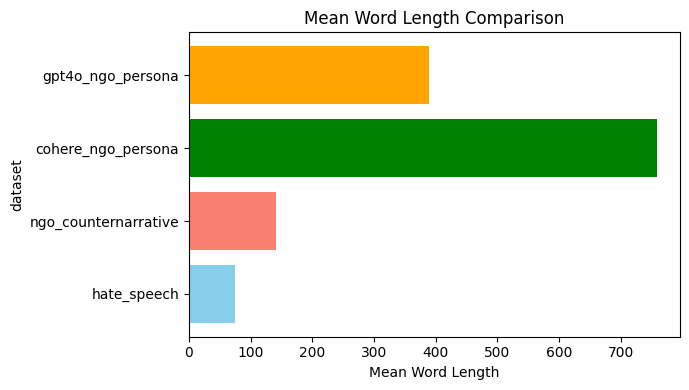


 plotting the stats and emotions classifications across the data columns



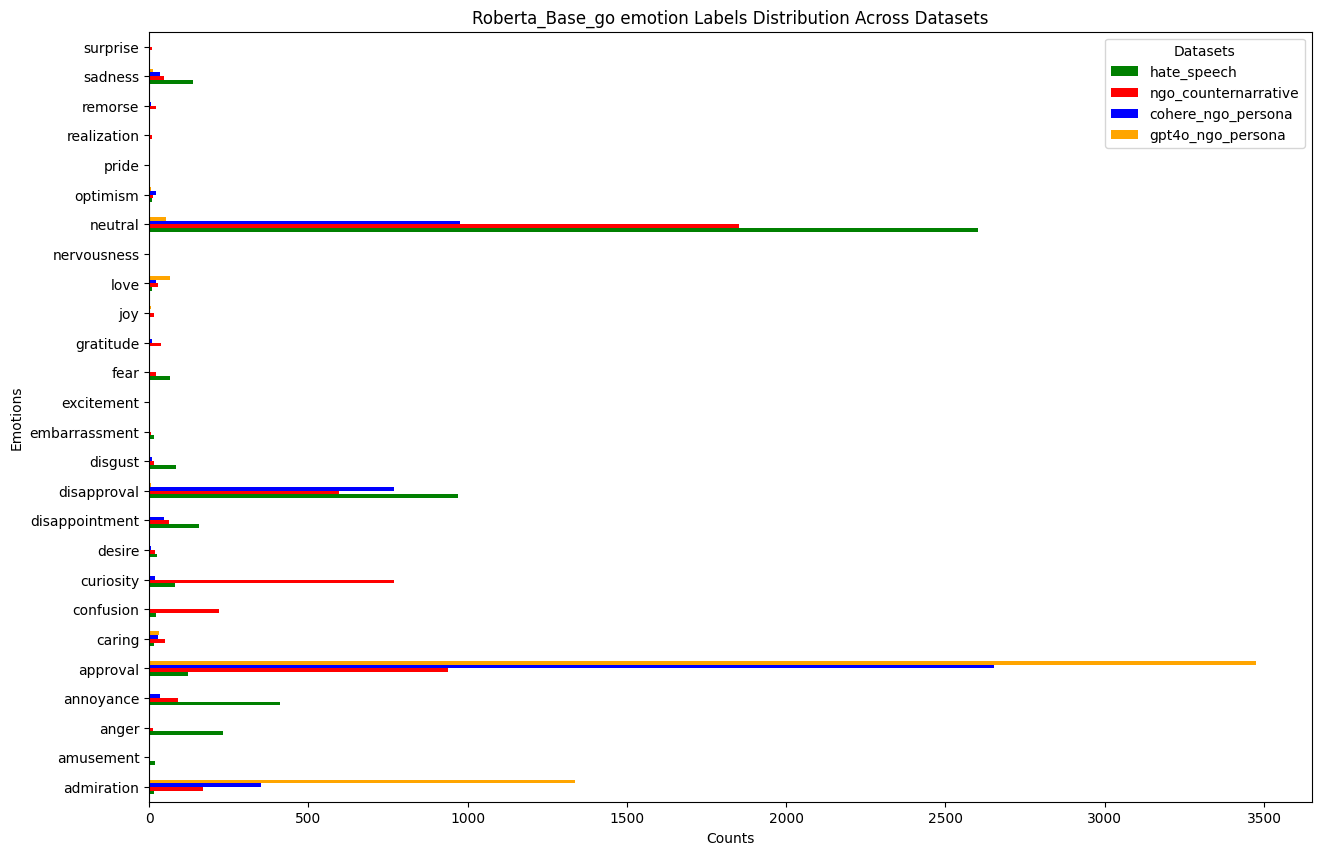


 plotting the sankey charts for the emotions in each columns



In [37]:
import random
if __name__ == "__main__":
    emotion = BERTemotion()
    stats = Stats()

    counter_ngo_df = pd.read_csv('/content/drive/MyDrive/PhD with Rawat/milanlp/ngo_output/cohere_gpt4o_ngo_prompt.csv')
    columns = ['HATE_SPEECH', 'COUNTER_NARRATIVE', 'cohere_ngo_prompt', 'gpt4o_ngo_prompt']
    new_name = ['hate_speech', 'ngo_counternarrative', 'cohere_ngo_persona', 'gpt4o_ngo_persona' ]

    # Rename columns
    rename_dict = dict(zip(columns, new_name))
    counter_ngo_df.rename(columns=rename_dict, inplace=True)

    #no more samples, we go all in
    counter_ngo_df = counter_ngo_df[new_name]
    # counter_ngo_df = counter_ngo_df[new_name].sample(n=10, random_state=42).reset_index(drop=True)

    print(f'the shape of my current sample is {counter_ngo_df.shape}')

    #exploratory data analysis
    for item in new_name:
      stats.exploratory_data_analysis(counter_ngo_df,item, item)
      counter_ngo_df[f"{item}_emotion"] = counter_ngo_df[item].apply(lambda x: emotion.predict(x)['emotion'])
      counter_ngo_df[f"{item}_score"] = counter_ngo_df[item].apply(lambda x: emotion.predict(x)['emotion_score'])

    print("\n plotting the word distribution across the data columns\n")
    stats.plot_mean_word_length(counter_ngo_df, 'hate_speech', 'ngo_counternarrative', 'cohere_ngo_persona', 'gpt4o_ngo_persona')

    print("\n plotting the stats and emotions classifications across the data columns\n")
    emotion.plot_emotion_distribution(
    counter_ngo_df['hate_speech_emotion'],
    counter_ngo_df['ngo_counternarrative_emotion'],
    counter_ngo_df['cohere_ngo_persona_emotion'],
    counter_ngo_df['gpt4o_ngo_persona_emotion'],
    'hate_speech',
    'ngo_counternarrative',
    'cohere_ngo_persona',
    'gpt4o_ngo_persona'
)

    print("\n plotting the sankey charts for the emotions in each columns\n")

        # Create a Sankey chart for each column
for col in new_name:
    emotion.create_sankey_chart(counter_ngo_df[f"{col}_emotion"], col)

##################################################

In [ ]:
# Prepare data for Sankey chart
emotion_counts = {}
for col in columns:
    emotion_counts[col] = counter_df[f"{col}_emotion"].value_counts().to_dict()

emotion_counts

- `[emotion_counts[col].keys() for col in columns]
` : For each column in columns, it retrieves the keys of the dictionary emotion_counts[col]. The result is a list of dictionaries' `keys: [['joy', 'anger'], ['joy', 'sadness'], ['anger', 'surprise']]` (example).

- The `*` unpacks the list into separate arguments for the `set().union()` function. Combines all the individual lists into a single set, removing any duplicates.

-For example, if the input is `[['joy', 'anger'], ['joy', 'sadness'], ['anger', 'surprise']]`, the output is `{'joy', 'anger', 'sadness', 'surprise'}`.

In [ ]:
import random
# Build nodes and links
emotion_counts = {}
'''for col in columns:
    emotion_counts[col] = counter_df[f"{col}_emotion"].value_counts().to_dict()'''

for col in columns:
    emotion_counts[col] = pd.Series(counter_df[f"{col}_emotion"]).value_counts().to_dict()

all_emotions = list(set().union(*[emotion_counts[col].keys() for col in columns]))
all_columns = columns
# Nodes: emotions + columns
nodes = all_emotions + all_columns
node_indices = {node: idx for idx, node in enumerate(nodes)}

# Links: emotion flows between columns
links = {
    "source": [],
    "target": [],
    "value": [],
    "color": []
}

def random_color():
  return f"#{random.randint(0, 0xFFFFFF):06x}"

for col in columns:
    for emotion, count in emotion_counts[col].items():
        links["source"].append(node_indices[emotion])
        links["target"].append(node_indices[col])
        links["value"].append(count),
        links["color"].append(random_color())

# Create Sankey chart
fig = go.Figure(go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=nodes
    ),
    link=dict(
        source=links["source"],
        target=links["target"],
        value=links["value"],
        color=links["color"]
    )
))

fig.update_layout(title_text="Emotion Flow Across Columns", font_size=10)
fig.show()


In [ ]:
!pip install cohere --quiet

import cohere

os.environ["COHERE_PROD"] = userdata.get("COHERE_PROD")

# api_key = userdata.get("OPENAI_KEY")


class Cohere_ai:
   def prompt_counter(self, event, model_name= 'command'):
    prompt = f"generate a counter-narrative to this hateful comment '{event}'. omit explanations and provide only the counter narrative"
    co_api = cohere.Client(userdata.get("COHERE_API"))
    response = co_api.chat(
        message=prompt,
        model=model_name,
        temperature=0.3
    )
    return response.text

cohere_ai = Cohere_ai()

event = 'The feminist theory makes no sense. It is about equality, for women only.'
cohere_ai.prompt_counter(event, model_name= 'command')
# cohere_prompt = prompt_counter()
# cohere_prompt(event, co_model)


In [ ]:
def prompt_counter(event, model_name= 'command'):
    prompt = f"generate a counter-narrative to this hateful comment '{event}'. omit explanations and provide only the counter narrative"
    co_api = cohere.Client(userdata.get("COHERE_API"))
    response = co_api.chat(
        message=prompt,
        model=model_name,
        temperature=0.3
    )
    return response.text

co_model = 'command'
event = 'The feminist theory makes no sense. It is about equality, for women only.'
prompt_counter(event = event, model_name = co_model)
